## Using transformer models to extract information from text

from https://huggingface.co/course/:

What is NLP?

NLP is a field of linguistics and machine learning focused on understanding everything related to human language. The aim of NLP tasks is not only to understand single words individually, but to be able to understand the context of those words.

The following is a list of common NLP tasks, with some examples of each:

* Classifying whole sentences: Getting the sentiment of a review, detecting if an email is spam, determining if a sentence is grammatically correct or whether two sentences are logically related or not
    
* Classifying each word in a sentence: Identifying the grammatical components of a sentence (noun, verb, adjective), or the named entities (person, location, organization)

* Generating text content: Completing a prompt with auto-generated text, filling in the blanks in a text with masked words

* Extracting an answer from a text: Given a question and a context, extracting the answer to the question based on the information provided in the context

* Generating a new sentence from an input text: Translating a text into another language, summarizing a text

NLP isn’t limited to written text though. It also tackles complex challenges in speech recognition and computer vision, such as generating a transcript of an audio sample or a description of an image.

Hugging Face Model Hub

https://huggingface.co/models

Examples

https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21

https://huggingface.co/oliverguhr/german-sentiment-bert?text=Das+ist+gar+nicht+mal+so+schlecht

In [20]:
%%capture

import sys

# install with pip
# !{sys.executable} -m pip install transformers
# !{sys.executable} -m pip install pyreadr
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install scipy

# install with conda
# !conda install --yes --prefix {sys.prefix} transformers
# !conda install --yes --prefix {sys.prefix} pyreadr
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} sklearn
# !conda install --yes --prefix {sys.prefix} scipy

from transformers import pipeline
import pyreadr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats

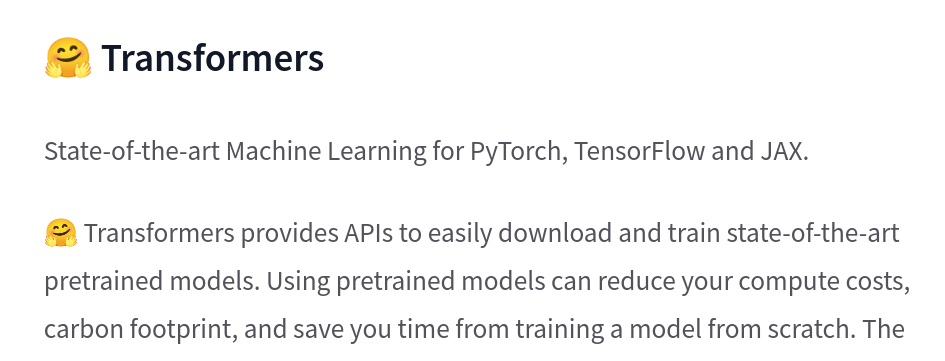

In [8]:
classifier = pipeline("sentiment-analysis")

classifier("I've been waiting for this awesome course my whole life!")

[{'label': 'POSITIVE', 'score': 0.9998290538787842}]

In [9]:
german_classifier = pipeline("sentiment-analysis",model="oliverguhr/german-sentiment-bert",return_all_scores=True)

german_classifier("Extrem happy heute, toller Kurs!")

[[{'label': 'positive', 'score': 0.9663448929786682},
  {'label': 'negative', 'score': 0.02535451389849186},
  {'label': 'neutral', 'score': 0.008300610817968845}]]

In [10]:
unmasker = pipeline("fill-mask")
unmasker("This course will teach you all about <mask> models.", top_k=2)

[{'score': 0.19619838893413544,
  'token': 30412,
  'token_str': ' mathematical',
  'sequence': 'This course will teach you all about mathematical models.'},
 {'score': 0.040527306497097015,
  'token': 38163,
  'token_str': ' computational',
  'sequence': 'This course will teach you all about computational models.'}]

In [11]:
generator = pipeline("text-generation", model="distilgpt2")
generator(
    "In this course, we will teach you how to",
    max_length=30,
    num_return_sequences=2,
)

[{'generated_text': 'In this course, we will teach you how to play in one-on-one sessions with real players and other people. One-on-one'},
 {'generated_text': 'In this course, we will teach you how to get started, build your skills and build your own tools. We’ll put you through more'}]

There are three main steps involved when you pass some text to a pipeline:

    The text is preprocessed into a format the model can understand.
    The preprocessed inputs are passed to the model.
    The predictions of the model are post-processed, so you can make sense of them.

Some of the currently available pipelines are:

    feature-extraction (get the vector representation of a text)
    fill-mask
    ner (named entity recognition)
    question-answering
    sentiment-analysis
    summarization
    text-generation
    translation
    zero-shot-classification

You can feed lists of texts to pipelines.
In principle, you could loop over pipelines.

In [12]:
classifier(["This restaurant is awesome", "This restaurant is awful"])

[{'label': 'POSITIVE', 'score': 0.9998743534088135},
 {'label': 'NEGATIVE', 'score': 0.9996669292449951}]

Especially when you are working with GPUs, which you need when you analyse a lot of text (CPUs are much slower for these kinds of operations):

You need to set the batch size, how much texts the model feeds at once to the model, so that it still fits RAM of the GPU and other parameters, see

https://huggingface.co/docs/transformers/main_classes/pipelines#pipeline-batching

So at some point you are better off writing your own loops directly in pytorch, see https://pytorch.org/docs/stable/data.html

To load your custom data in huggingface transformers you need to define a class that does that, but Hugging Face datasets has some prebuilt ones, see https://huggingface.co/docs/datasets/loading 

Also the Hugging Face dataset hub offers a lot of data sets (also huge ones) that can be loaded super-easily, see https://huggingface.co/datasets

## Combine text analysis results with data from surveys
### Replicating findings of a scientific publication

"Validating daily social media macroscopes of emotions"

https://www.nature.com/articles/s41598-022-14579-y

In [13]:
# from https://stackoverflow.com/questions/40996175/loading-a-rds-file-in-pandas

# the file is from the github repository of the publication
# https://github.com/maxpel/SocialMediaMacroscopes

result = pyreadr.read_r('cdplstandard.RDS')

# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key

# extract the pandas data frame 
standarddf = result[None]

# to date object
standarddf['date_day'] = pd.to_datetime(standarddf['date_day'])

# to time range of survey
standarddf = standarddf.loc[(standarddf['date_day']>='2020-11-11') & (standarddf['date_day']<='2020-11-30')]

standarddf

,date_day,prop_good,sent,sentA,sentB,sent_roll3_weighted,sentA_roll3_weighted,sentB_roll3_weighted,sent_roll3_weighted_shifted1,sentA_roll3_weighted_shifted1,sentB_roll3_weighted_shifted1,sent_roll3_weighted_shifted2,sentA_roll3_weighted_shifted2,sentB_roll3_weighted_shifted2,sentA_pos_roll3_weighted_shifted1,sentA_neg_roll3_weighted_shifted1,sentB_pos_roll3_weighted_shifted1,sentB_neg_roll3_weighted_shifted1
4,2020-11-11,0.645394,-0.092979,-0.120723,-0.065234,-0.044990,-0.057526,-0.032453,-0.037658,-0.035755,-0.039561,-0.052630,-0.048885,-0.056375,0.012164,0.047919,-0.031626,0.007935
5,2020-11-12,0.625644,-0.010992,0.002503,-0.024487,-0.039622,-0.038742,-0.040501,-0.051353,-0.047523,-0.055183,-0.050103,-0.034181,-0.066024,0.000704,0.048227,-0.047672,0.007511
6,2020-11-13,0.606379,-0.053836,-0.030294,-0.077378,-0.053027,-0.049871,-0.056184,-0.049503,-0.033828,-0.065177,-0.058509,-0.037224,-0.079794,0.004857,0.038685,-0.034898,0.030279
7,2020-11-14,0.598761,-0.083013,-0.072666,-0.093359,-0.052114,-0.036636,-0.067592,-0.057744,-0.036130,-0.079358,-0.045848,-0.015309,-0.076386,0.009520,0.045650,-0.026328,0.053030
8,2020-11-15,0.609519,-0.039853,-0.010408,-0.069298,-0.060300,-0.039814,-0.080785,-0.047440,-0.018248,-0.076633,-0.007445,0.019339,-0.034228,0.021502,0.039750,-0.024410,0.052222
9,2020-11-16,0.636596,-0.021604,0.025716,-0.068923,-0.050121,-0.022138,-0.078103,-0.008710,0.017095,-0.034515,0.000215,0.006517,-0.006087,0.038592,0.021497,-0.008579,0.025936
10,2020-11-17,0.640625,0.040925,0.040905,0.040945,-0.007762,0.018308,-0.033832,0.001813,0.006429,-0.002804,0.016625,0.005869,0.027381,0.027815,0.021386,-0.007287,-0.004483
11,2020-11-18,0.653232,-0.014795,-0.050543,0.020953,0.001049,0.005716,-0.003617,0.017233,0.006969,0.027497,0.014280,0.016105,0.012455,0.021603,0.014635,0.022042,-0.005455
12,2020-11-19,0.654845,0.024147,0.028484,0.019811,0.016693,0.006110,0.027276,0.014726,0.017053,0.012400,0.054080,0.075261,0.032899,0.014826,-0.002227,0.010831,-0.001569
13,2020-11-20,0.659050,0.035170,0.074209,-0.003870,0.014535,0.016628,0.012441,0.053925,0.074979,0.032871,0.097554,0.128136,0.066973,0.067948,-0.007031,0.045811,0.012940


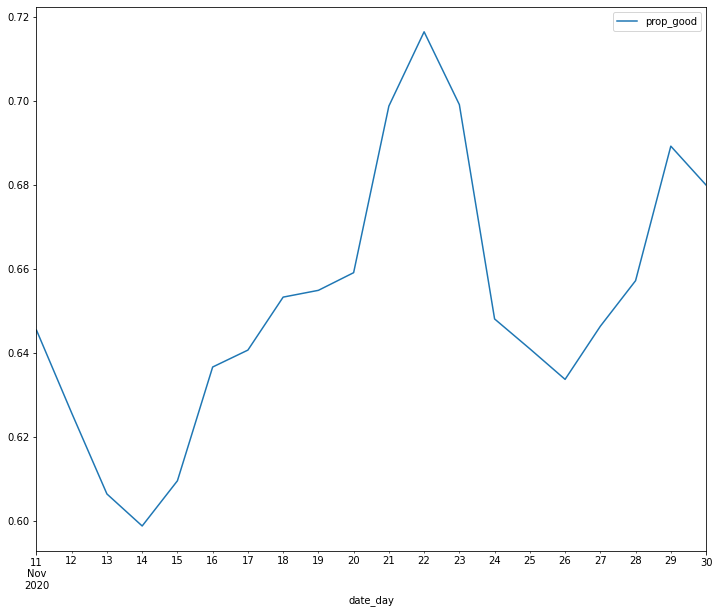

In [14]:
# plot the survey
standarddf.plot(x="date_day", y=["prop_good"], kind="line", figsize=(12, 10))
 
plt.show()

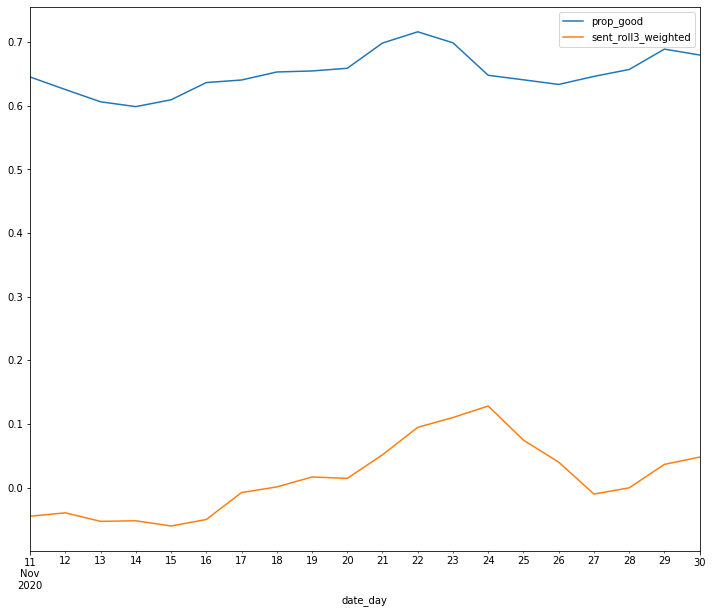

In [15]:
# plot the survey and the text sentiment measure
stdpl = standarddf.plot(x="date_day", y=["prop_good","sent_roll3_weighted"], kind="line", figsize=(12, 10))
 
plt.show()

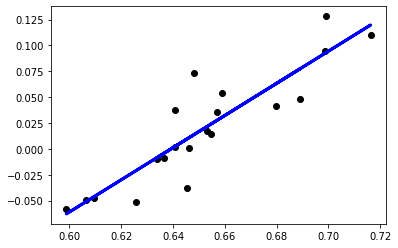

,prop_good,sent_roll3_weighted_shifted1
prop_good,1.000000,0.895321
sent_roll3_weighted_shifted1,0.895321,1.000000


In [29]:
# investigate the relationship between survey and text sentiment measure further
reg = LinearRegression()

reg.fit(standarddf[['prop_good']],standarddf[['sent_roll3_weighted_shifted1']])

plt.scatter(standarddf[['prop_good']], standarddf[['sent_roll3_weighted_shifted1']],  color='black')
plt.plot(standarddf[['prop_good']], reg.predict(standarddf[['prop_good']]), color='blue', linewidth=3)
plt.show()

standarddf[['prop_good','sent_roll3_weighted_shifted1']].corr(method='pearson')

[[0.51611238]]
[0.64178639]


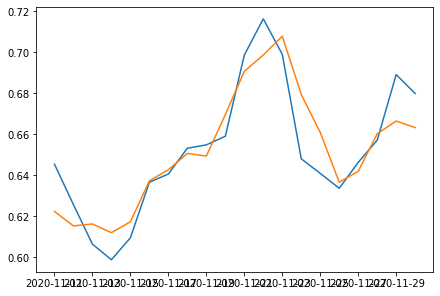

In [31]:
# rescale text sentiment measure to overlay the two lines and inspect them visually

reg.fit(standarddf[['sent_roll3_weighted_shifted1']],standarddf[['prop_good']])

# that's how much we have to scale the text sentiment measure
print(reg.coef_)

# that's how much we have to offset the text sentiment measure
print(reg.intercept_)

# start the plot
fig, ax = plt.subplots(constrained_layout=True)

y=standarddf[['sent_roll3_weighted_shifted1']]

# transform according to the linear model
y_trans = reg.intercept_+y*reg.coef_

ax.plot(standarddf[['date_day']],standarddf[['prop_good']])

ax.plot(standarddf[['date_day']],y_trans)

plt.show()

## If you want to do more

* Play around with the huggingface model hub and load different models in pipelines to try them out. Can you think of research questions where a specific model would come in handy?

* In the github repository (https://github.com/maxpel/SocialMediaMacroscopes), you find the file pl.RDS, can you repeat the above analysis using "sent_roll3_weighted" from that data file? What do you find? If you check in the paper, which figure did you replicate now?

* Both data files contain a colum called "sent", what do you find when you plot that variable? Can you replicate the smoothing of values over 3 days?

* Do you manage to manage to include the second y axis on the right on the last plot? (check out the plot in the paper for reference)